# Wikipedia Kaggle Data Peak

In [1]:
import pandas as pd
import numpy as np
import gensim
import spacy
import nltk
import json
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

import pyLDAvis as pyldavis
import pyLDAvis.sklearn

%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


Read dataset given by Kaggle of Wikipedia articles.

In [2]:
import sqlite3
conn = sqlite3.connect('../data/wiki-kaggle-17_18.db')
crsr = conn.cursor()

Peak into the tables.

In [3]:
query = """
        SELECT 
            ARTICLE_ID,
            REPLACE(GROUP_CONCAT(SECTION_TEXT, ' '), '\n', ' ') AS CONTENT 
        FROM ARTICLES 
        GROUP BY ARTICLE_ID
        """

for chunk in pd.read_sql_query(query, conn, chunksize=500000):
    df = chunk
    break

In [4]:
raw_data = []
clean_data = []

def valid(txt):
    if txt is None: return
    if txt in ENGLISH_STOP_WORDS: return
    if len(txt) <= 3: return
    return True

for idx, row in df.iterrows():
    raw_data += [row["CONTENT"]]
    clean_text = re.sub("[^a-zA-Z]+", " ", row["CONTENT"])
    clean_text = clean_text.lower()
    split_text = [t for t in clean_text.split(" ") if valid(t)]
    clean_data += [" ".join(split_text)]

In [5]:
pd.DataFrame(clean_data)

,0
0,anarchism political philosophy advocates self ...
1,autism neurodevelopmental disorder characteriz...
2,percentage diffusely reflected sunlight relati...
3,writing cursive forms named plural letter vowe...
4,alabama state southeastern region united state...
5,achilles nereid cymothoe attic figure kantharo...
6,abraham lincoln february april american politi...
7,aristotle aristot ancient greek philosopher sc...
8,american paris jazz influenced orchestral piec...
9,academy award best production design recognize...


In [6]:
word_ids = []
vocab = {}
for row in clean_data:
    bag = {}
    row = row.split(" ")
    row = [word for word in row if word]
    for word in row:
        if word in vocab:vocab[word] += 1
        else: 
            word_ids += [word]
            vocab[word] = 1
    
freq_bag = []
for word in vocab.keys():
    freq_bag += [{ "text": word, "count": vocab[word] }]

In [7]:
freq_df = pd.DataFrame(freq_bag)
sorted_freq = freq_df.sort_values("count")
counts = []
labels = []
for cnt in sorted_freq.values:
    counts += [cnt[0]]
    labels += ["{}, {}".format(cnt[1], cnt[0])]

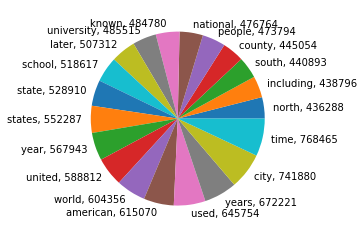

In [8]:
plt.pie(counts[-20:], labels=labels[-20:])
plt.show()

In [9]:
no_topics = 20
no_top_words = 10

In [10]:
def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_label = "Topic {}".format(topic_idx)
        words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics += [[*words]]
    return topics

In [11]:
def eval_model(best=None, model=None, vect=None, use_simple=False):
    print("= SUMMARY", "="*50, "\n")
    if best:
        best_model = best.best_estimator_
        print("Params:\t{}".format(best.best_params_))
        print("Log Likelihood:\t{}".format(best.best_score_))
        print("Perplexity:\t{}".format(best_model.perplexity(vect)))
        return

    data_dense = vect.todense()
    print("Sparsicity:\t{} %".format(((data_dense > 0).sum()/data_dense.size)*100))
    if not use_simple:
        print("Log Likelihood:\t{}".format(model.score(vect)))
        print("Perplexity:\t{}".format(model.perplexity(vect)))
    print(json.dumps(model.get_params(), indent=2))

In [12]:
vect = CountVectorizer(ngram_range=(1,1), stop_words="english")
cnt = vect.fit_transform(clean_data)
cnt_feature_names = vect.get_feature_names()

In [13]:
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
lda_model = lda.fit(cnt)

In [14]:
lda_topics = display_topics(lda_model, cnt_feature_names, no_top_words)
pd.DataFrame(lda_topics)

,0,1,2,3,4,5,6,7,8,9
0,india,indian,russian,soviet,russia,pakistan,khan,iran,muslim,islamic
1,medical,health,food,disease,used,blood,treatment,hospital,drug,patients
2,species,color,till,text,green,genus,plant,family,plants,tree
3,team,season,league,game,club,world,games,player,championship,football
4,german,french,born,france,germany,september,paris,march,october,italian
5,party,government,united,state,election,president,states,national,general,elected
6,language,english,used,languages,region,spanish,century,word,people,portuguese
7,linear,example,number,used,theory,function,data,value,point,time
8,army,battle,british,military,royal,forces,king,general,later,force
9,john,american,born,york,james,william,london,george,house,robert
